# Session 13: Image classification with Convolutional NNs

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

Goals for today:
    - Train an MNIST image classifier based on CNNs
    - Homework: Create an structure similar to LetNet5


This is a personal wrap-up of all the material provided by [Google's Deep Learning course on Udacity](https://www.udacity.com/course/deep-learning--ud730), so all credit goes to them. 

**ALPER KOCABIYIK  & GONZALO ALVAREZ**

# On convolutional NNs

- Check out the [following slides](http://www.ucsp.edu.pe/ciet/mlss16/file/shlens.pdf)

- The following [paper](https://arxiv.org/pdf/1603.07285v1.pdf) is very nice to understand the arithmetic of convolution operations in 2D

- Check out the following video for a quick introduction to CNNs

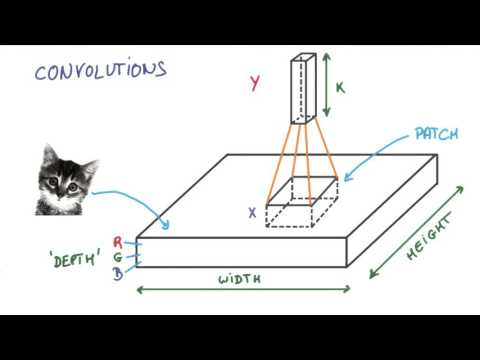

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('jajksuQW4mc') 

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


In [3]:
# Lets check what version of tensorflow we have installed. The provided scripts should run with tf 1.0 and above

print(tf.__version__)

1.8.0


## Loading MNIST database

In [4]:
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
mnist = fetch_mldata('MNIST original')

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
images = mnist.data.astype(np.float32)
labels = mnist.target

train_dataset,test_dataset,train_labels,test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

train_dataset,valid_dataset,train_labels,valid_labels = train_test_split(train_dataset, train_labels, test_size=0.33, random_state=42)

# Separate a smaller data set for training (20000 images) 
N = 20000

train_dataset = train_dataset[:N,:]
train_labels = train_labels[:N]

In [0]:
N2=10000
valid_dataset = valid_dataset[:N2,:]
valid_labels = valid_labels[:N2]
test_dataset = test_dataset[:N2,:]
test_labels = test_labels[:N2]

### Reformat labels as 1-hot encodings and images into tensors

**Take care! Input image set is now a 4-dimensional tensor! num_images $\times$ image_width $\times$ image_height $\times$ num_channels**

For gray-scale MNIST images, the number of imput channels is one

In [7]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (20000, 28, 28, 1) (20000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [0]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])



Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive to train computationally, so we'll limit its depth and number of fully connected nodes.


## Lets train our first CNN

Two 5x5 convolutional layers with stride 2 and Relu non-linear layers, followed by a fully connected year with soft-max.

<img src="CNN1.png">

The number of parameters of the network is:

- First convolutional Layer: 1 x 16 x 5 x 5 = 400 parameters (+16 of bias)
- Second convolutional Layer: 16 x 16 x 5 x 5 = 6400 parameters (+16 of bias)
- Fully Connected Layer: 224 x 64 = 14336 parameters (+64 of bias)
- Last fully connected layer: 640 parameters (+10 of bias)

** Total: 21882 parameters **

The following code implements the above structure step by step. 

In [9]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden = 64

graphCC = tf.Graph()

with graphCC.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) ##Stride =2 !!
    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases   
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss) 
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [10]:
num_steps = 1001

with tf.Session(graph=graphCC) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 38.748158
Minibatch accuracy: 9.4%
Validation accuracy: 18.4%
Minibatch loss at step 100: 0.312885
Minibatch accuracy: 89.8%
Validation accuracy: 90.5%
Minibatch loss at step 200: 0.137565
Minibatch accuracy: 95.3%
Validation accuracy: 94.2%
Minibatch loss at step 300: 0.052938
Minibatch accuracy: 97.7%
Validation accuracy: 95.2%
Minibatch loss at step 400: 0.050666
Minibatch accuracy: 97.7%
Validation accuracy: 95.8%
Minibatch loss at step 500: 0.058921
Minibatch accuracy: 97.7%
Validation accuracy: 93.7%
Minibatch loss at step 600: 0.072516
Minibatch accuracy: 96.9%
Validation accuracy: 95.7%
Minibatch loss at step 700: 0.041953
Minibatch accuracy: 98.4%
Validation accuracy: 95.7%
Minibatch loss at step 800: 0.112408
Minibatch accuracy: 96.9%
Validation accuracy: 95.8%
Minibatch loss at step 900: 0.099838
Minibatch accuracy: 96.9%
Validation accuracy: 95.8%
Minibatch loss at step 1000: 0.014717
Minibatch accuracy: 100.0%
Validation accuracy: 95.3

## Problem 2

1) Implement the above network using TF predefined layers. Introduce L2-regularization and select the regularization parameter (the same for all layers) using CV.

2) Modify the computation graph to extract the model parameters (weight and bias of the different dense layers). Check the function [tf.global_variables](https://www.tensorflow.org/api_docs/python/tf/global_variables). **How many parameters the network has?**.

3) Represent the CNN output for different input images.

**This problem is part of the last assigment of the course!**

In [0]:
def print_global_var():  
  global_vars = tf.global_variables()
  print (global_vars)
  print('\nNumber of global varibles: %d.\n' %(len(global_vars)))
  for var in global_vars:
    name = var.name.split(':')[0].split('/')
    layer = name[0]
    if(layer.split('_')[0] == "Layer"):
      print(layer, name[1:])
    else:
      print(name) 

In [12]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden = 64
num_labels = 10
image_size = 28
num_channels = 1

graphCC_v2 = tf.Graph()

with graphCC_v2.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # We feed the beta parameter as a placeholder
    tf_beta = tf.placeholder(tf.float32)
    
    # Regularizer
    regularizer = tf.contrib.layers.l2_regularizer(scale=tf_beta)

    input_layer = tf.reshape(tf_train_dataset, [batch_size, image_size, image_size, num_channels])

    def model_tf(tf_data, reuse):  
      # Convolutional Layer #1
      conv1 = tf.layers.conv2d(inputs=tf_data, filters=depth, 
                               kernel_size=patch_size, reuse=reuse,
                               padding="same",activation=tf.nn.relu, 
                               kernel_regularizer=regularizer, name='Layer1')
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
      # Convolutional Layer #2 
      conv2 = tf.layers.conv2d(inputs=pool1,filters=depth,
                               kernel_size=patch_size, reuse=reuse,
                               padding="same",activation=tf.nn.relu,
                               kernel_regularizer=regularizer, name='Layer2')
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
      pool2_flat = tf.reshape(pool2, [-1, image_size // 4 * image_size // 4 * depth])

      # Dense Layer
      dense = tf.layers.dense(inputs=pool2_flat, units=num_hidden, 
                              activation=tf.nn.relu, reuse=reuse, name='Layer3')
      # Logit Layer
      logits = tf.layers.dense(inputs=dense, units=num_labels,reuse=reuse, name='Layer4')   
      return logits
                            
    # Logits
    logits = model_tf(tf_train_dataset, None)
    
    # Loss
    loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    l2_loss = tf.losses.get_regularization_loss()
    loss += l2_loss
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss) 
    
    # Global Variables
    print_global_var()
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model_tf(tf_valid_dataset, True))
    test_prediction = tf.nn.softmax(model_tf(tf_test_dataset, True)) 
  

[<tf.Variable 'Layer1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'Layer1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Layer2/kernel:0' shape=(5, 5, 16, 16) dtype=float32_ref>, <tf.Variable 'Layer2/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Layer3/kernel:0' shape=(784, 64) dtype=float32_ref>, <tf.Variable 'Layer3/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Layer4/kernel:0' shape=(64, 10) dtype=float32_ref>, <tf.Variable 'Layer4/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'Layer1/kernel/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'Layer1/kernel/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'Layer1/bias/Adam:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Layer1/bias/Adam_1:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Layer2/kernel/Adam:0' shape=(5, 5, 16, 16) dtype=float32_ref>

In [0]:
def train_L2Reg(graph, num_steps, beta):
  
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("\nRegularization parameter = %r\n" %(beta))
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 200 == 0):
                print('Minibatch loss at step %d: %f' % (step, l))
                print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        valid_accuracy,test_accuracy = accuracy(valid_prediction.eval(), valid_labels), accuracy(test_prediction.eval(), test_labels)
    
    return valid_accuracy,test_accuracy

In [14]:
num_steps = 1001
beta = np.logspace(-3, -1, 3)
val_performace = np.zeros(beta.shape)
test_performace = np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i] = train_L2Reg(graphCC_v2, num_steps, beta[i])  


Regularization parameter = 0.001

Minibatch loss at step 0: 82.426453
Minibatch accuracy: 9.4%
Validation accuracy: 9.7%
Minibatch loss at step 200: 0.296583
Minibatch accuracy: 91.4%
Validation accuracy: 90.8%
Minibatch loss at step 400: 0.224566
Minibatch accuracy: 95.3%
Validation accuracy: 95.1%
Minibatch loss at step 600: 0.066617
Minibatch accuracy: 98.4%
Validation accuracy: 95.6%
Minibatch loss at step 800: 0.130652
Minibatch accuracy: 96.9%
Validation accuracy: 95.9%
Minibatch loss at step 1000: 0.087408
Minibatch accuracy: 96.9%
Validation accuracy: 96.5%

Regularization parameter = 0.01

Minibatch loss at step 0: 42.937046
Minibatch accuracy: 13.3%
Validation accuracy: 16.0%
Minibatch loss at step 200: 0.408699
Minibatch accuracy: 90.6%
Validation accuracy: 91.5%
Minibatch loss at step 400: 0.207910
Minibatch accuracy: 97.7%
Validation accuracy: 94.2%
Minibatch loss at step 600: 0.214510
Minibatch accuracy: 94.5%
Validation accuracy: 94.8%
Minibatch loss at step 800: 0.2165

Test accuracy: 96.62
0.001


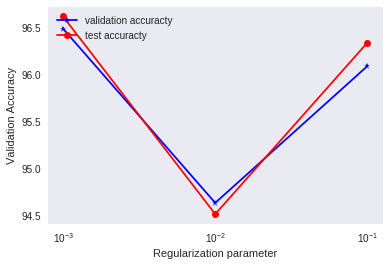

In [15]:
plt.semilogx(beta,val_performace,'b-*', label='validation accuracty')
plt.semilogx(beta,test_performace,'r-o', label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend(loc=2)
plt.grid()

print ("Test accuracy: %r" %(np.max(test_performace)))
betaCV = beta[np.argmax(val_performace)]
print (betaCV)

## A more complicated CNN: Le-Net 5

The goal is to implement the following network

<img src="CNN2.png">

The number of parameters of the network is:

- First convolutional Layer: 1 x 16 x 5 x 5 = 400 parameters (+16 of bias)
- Second convolutional Layer: 16 x 64 x 5 x 5 = 25600 parameters (+64 of bias)
- **Fully Connected Layer:  3136 x 128 = 401408 parameters (+128 of bias)**
- Fully Connected Layer: 128 x 128 = 16384 parameters (+128 of bias)
- Last fully connected layer: 1280 parameters (+10 of bias)

** Total: 445418 parameters **


We will introduce dropout and [max pooling](http://cs231n.github.io/convolutional-networks/#pool) (instead of stride 2 convolution)

In [16]:
batch_size = 128
patch_size = 5
depth = 16
depth_2 = 64
num_hidden = 128
drop_out = 0.5

graph_CC_LeNet5_v2 = tf.Graph()

with graph_CC_LeNet5_v2.as_default():

    global_step = tf.Variable(0)
    
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth_2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))

    #size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2      #VALID PADDING, AVG_POOL=2
    
    size3 = image_size// 4   #SAME PADDING, AVG_POOL=2
    
    layer3_weights = tf.Variable(tf.truncated_normal([size3 * size3 * depth_2, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_hidden], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer5_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))    
  
    # Model.
    
    pad='SAME'
    
    def model_pol_2(data,prob):
        # C1 input 28 x 28
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding=pad)
        bias1 = tf.nn.relu(conv1 + layer1_biases)
        # S2 input 24 x 24
        pool2 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding=pad)
        # C3 input 12 x 12
        conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding=pad)
        bias3 = tf.nn.relu(conv3 + layer2_biases)
        # S4 input 8 x 8
        pool4 = tf.nn.max_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding=pad)
        # F5 input 4 x 4
        shape = pool4.get_shape().as_list()
        reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden5 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        #F6
        drop5=tf.nn.dropout(hidden5,prob)
        hidden6=tf.nn.relu(tf.matmul(hidden5,layer4_weights)+layer4_biases)
        #drop6=tf.nn.dropout(hidden6,prob)
        return tf.matmul(hidden6, layer5_weights) + layer5_biases
  
    # Training computation.
    logits = model_pol_2(tf_train_dataset,drop_out)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss) 
    
    # Global Variables
    print_global_var()
        
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    # DROP_OUT is only used in TRAINING!!!
    valid_prediction = tf.nn.softmax(model_pol_2(tf_valid_dataset,1.))
    test_prediction = tf.nn.softmax(model_pol_2(tf_test_dataset,1.))
    
    saver = tf.train.Saver() 

[<tf.Variable 'Variable:0' shape=() dtype=int32_ref>, <tf.Variable 'Variable_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'Variable_3:0' shape=(5, 5, 16, 64) dtype=float32_ref>, <tf.Variable 'Variable_4:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_5:0' shape=(3136, 128) dtype=float32_ref>, <tf.Variable 'Variable_6:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Variable_7:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'Variable_8:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Variable_9:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'Variable_10:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'Variable_1/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'Variable_1/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>, <tf.Variable 'Variable_2/Adam:0' shape=(16,) dt

In [17]:
num_steps = 101

with tf.Session(graph=graph_CC_LeNet5_v2) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
       
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))   
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    mymodel = saver.save(session, "/tmp/model.ckpt")

Initialized
Minibatch loss at step 0: 269.625397
Minibatch accuracy: 8.6%
Validation accuracy: 10.3%
Minibatch loss at step 100: 0.339867
Minibatch accuracy: 89.8%
Validation accuracy: 90.3%
Test accuracy: 90.4%


## Problem 3

1) Modify the computation graph to extract the model parameters (weight and bias of the different dense layers). Check the function [tf.global_variables](https://www.tensorflow.org/api_docs/python/tf/global_variables). **How many parameters the network has?**.

2) Represent the CNN output for different input images.

**This problem is part of the last assigment of the course!**

In [18]:
# 2)

with tf.Session(graph=graph_CC_LeNet5_v2) as session:
    saver.restore(session, "/tmp/model.ckpt")
    test_pred = test_prediction.eval()
    print('Test accuracy: %.1f%%/n' % accuracy(test_pred, test_labels))

    # Print CNN test output for the first 10 images
    for i in range(10):
        print('%s \n' %test_pred[i,:])
        print('%s \n' %test_labels[i,:])

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Test accuracy: 90.4%/n
[5.5863953e-04 2.6901027e-03 1.4004746e-05 2.1293779e-05 2.5625917e-01
 1.9855624e-02 1.2598946e-04 7.1860075e-01 1.0196436e-03 8.5478276e-04] 

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 

[4.4691567e-03 1.6680981e-03 7.2365825e-04 6.9999567e-04 6.1528281e-06
 5.6395307e-04 9.4983610e-05 4.1343837e-06 9.9176884e-01 1.0873985e-06] 

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 

[2.28573889e-01 1.41817445e-05 1.13073576e-04 1.59647752e-05
 4.54156107e-05 8.39645881e-03 7.61460423e-01 3.28920432e-05
 6.91173307e-04 6.56493474e-04] 

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 

[6.3988045e-07 1.5166371e-08 1.3502991e-07 9.5124083e-04 4.1512349e-06
 9.9901187e-01 2.8145976e-05 1.0255495e-06 1.3186426e-06 1.4127301e-06] 

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 

[1.33374806e-06 3.44876025e-06 1.09224999e-07 1.11728205e-07
 1.64941264e-06 3.90374817e-06 5.72648560e-07 9.93420184e-01
 5.93699406e-06 6.56275079e-03] 

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 

[1